<a href="https://colab.research.google.com/github/thesaifmustafa8/TECHIN513/blob/main/InClass_Week5_Saif_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Saif Mustafa, Hyunsuk Bang, Vinitha Erusu, Soojin Hwang**

TECHIN 513 - Week 5 Assignment

**Setup**

* Importing all necessary tensorflow packages 

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

**Load Data**
* Loading data from Kaggle's Cats and Dogs Dataset
* Unzipping into Colab runtime directory 

In [7]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
!unzip -q kagglecatsanddogs_3367a.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   159M      0  0:00:04  0:00:04 --:--:--  166M
replace PetImages/Cat/0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

**Filter out corrupted images**
* Data cleanup step
* Filterting out badly-encoded images that do not feature the string "JFIF" in their header.
  *  `tf.compat.as_bytes("JFIF")` converts the string JFIF to bytes
  * `fobj.peek(10)` theoretically returns the first 10 bytes of the file
  * `is_jfif` then checks if the converted "JFIF" string is in the result of `fobj.peek`


In [9]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


**Generate dataset**

* Here we are using the keras preprocessing `image_data_from_directory` method to generate a **training** and **validation** dataset from the dog/cat image files. 

> `image_size = (180,180):` We need to standardize the image size for all files in our directory, so here we chose 180x180 pixels

> `batch_size = 32:` this parameter defines the number of samples we would like to propogate through our neural network. For example, for 32, the model will take the first 32 samples and train the network with it, followed by the next 32, until all the samples have propogated. Choosing a smaller number also helps us to reduce the run-time to train our network. 

> `validation_split = 0.2:` Keras uses this value (between 0 and 1) to proportionally split the dataset into training and validation. For example, if we choose 0.2, then 20% will be used for training, and rest 80% will be used for validation.

> `seed:` From my research, this seems like a random number used to uniquely identify the transformations in our dataset.

> `subset:` We're giving a label to our dataset of either training or validation.


In [10]:
image_size = (180, 180)

# batch_size defines
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages", 
    batch_size = batch_size, 
    image_size = image_size,
    validation_split=0.2,
    seed = 8, # to make the result reproducible
    subset="training" # needs validation split
) 

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages", 
    batch_size = batch_size, 
    image_size = image_size,
    validation_split=0.2,
    seed = 8,
    subset="validation" # needs validation split
) 

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


In [11]:
print(train_ds) # BatchDataset type object

<BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


**Data Augmentation**

We use data augmentation to increas the diversity of our training set by increasing the number of data points. We can do this in many way, but keras does this by applying minor changes the original file, for example, rotating it, cropping a little bit on the edges, flipping the image, resizing, or rescaling. It does this in a way that to the human eye, the image is still recognizable as the same but with slight non-cosmetic variation.

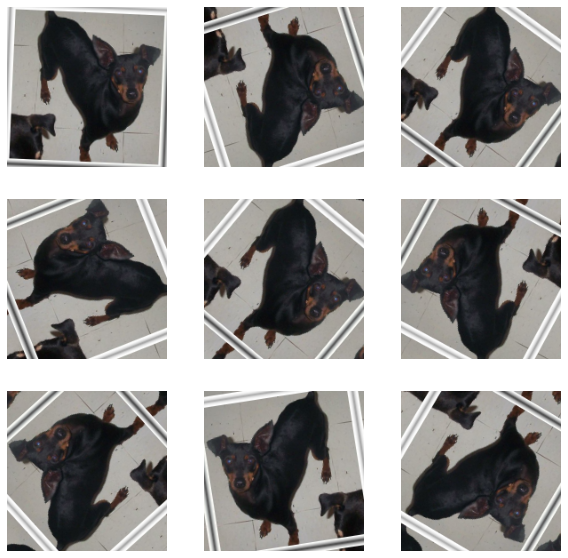

In [12]:
# defining a new data_augmentation sequential model to add horizontally and 
# vertically flipped versions of the original. 
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"), # adding a new layer
  layers.RandomRotation(0.2), # adding a new layer
])

# shows up as only one layer later on when printing because it treats 
# data_augmentation as one entity
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

**Visualize data**

Here we are plotting 9 random images in our dataset to show that it correctly categorizes dogs and cats as 1 and 0 respectively. 

The reason it is able to do so without any human intervention us because of Keras' preprocessing `image_dataset_from_directory` function, which automatically treats different directories as different clasees of data, so it derives the labels from the directory structure. Here's how it does that: 

Earlier when we called the `image_dataset_from_directory` method to create our training and validation datasets, we did not provide some optional parameters:

*   `labels = "inferred"`: means that keras will infer the labelling from the directory structure. Cats and Dogs are in separate folders, so it knows it must be two different classes of data. 
*   `label_mode = "int"`: means that for each category/class of data, assign an integer identifier. As we can see in the cell below, Keras has defined Dogs as 1 and Cats as 0.



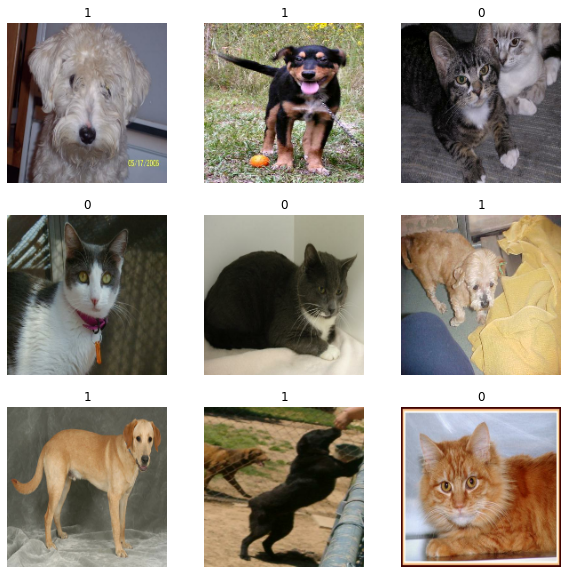

In [13]:
# it treats different directories as different classes
# labels are generated from the directory structure
# During preprocessing step, labels = 'inferred' by default
# label mode = 'int', and since we have 2 subfolders, we get either 0 or 1

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

**Build a Model**

> The make_model is going to be constructing our deep learning model:
*   `input_shape`: this is a tuple (N  x M) that represents the dimensions of our image, which in this case is 180 x 180
*   `num_classes`: Total number of classes in our dataset, which is 2 because we're doing Dogs and Cats only. 
*   `activation`: This is a parameter I defined to understand how our model performs using ReLu and Leaky ReLu activation functon.

> `x = layers.Rescaling(1.0 / 255)(x):` In this step, we are normalizing our data values by reassigning RGB (0-255) values to values between 0 and 1.0, which make it easier to process the data.

> `x = layers.BatchNormalization()(x):` this layer normalizes its output using the mean and standard deviation of the current batch of inputs for consistency in following layers.

> `x = layers.MaxPooling2D(3, strides=2, padding="same")(x):` In the maxpooling layer, we calculate the maximum value for patches of a feature map for the next layer:
![](https://www.machinecurve.com/wp-content/uploads/2020/01/Max-Pooling-2.png)

> `x = layers.GlobalAveragePooling2D(3, strides=2, padding="same")(x):` In this maxpooling layer, we calculate the average value for the entire tensor of a feature map for the next layer:
![](https://www.machinecurve.com/wp-content/uploads/2020/01/Global-Average-Pooling-3.png)

> `x = layers.Activation("relu")(x)` and `x = layers.LeakyReLU()(x):` an activation function defines the output of a tensor given an input value. Here, we are using Relu and Leaky Relu. Relu (Rectified linear unit) is a simple activation function which returns the f(x) = max(x,0), so any value below 0 is coded as 0, whereas leaky relu is similar to relu but it allows a small gradient when the unit is inactive, so there's lesser 0 values for the next layer:
![](https://qph.fs.quoracdn.net/main-qimg-04f503d241138caef4960cdb56face2d)

> `x = layers.Conv2D(32, 3, strides=2, padding="same")(x):` Here we are telling keras to resize the image to an output filter of 32x32 and by using a kernal of size 3x3. The stride signifies how many pixels the kernal must move between convolutions, and the padding represents how the function will compensate the loss of edge pixels, so "same" means it will pad with zeroes evenly to the left/right or up/down of the input. The output layer changed from 180x180 to 90x90 because stride is 2.

> `x = layers.SeparableConv2D(size, 3, padding="same")(x):` similar to Conv2D but it factorizes the convolution kernal of size 3x3 into further 2 smaller kernals:
![](https://miro.medium.com/max/1400/1*o3mKhG3nHS-1dWa_plCeFw.png)

> `x = layers.Dropout(0.5)(x):` this is a regularization layer we use to reduce the overfitting of our model. The 0.5 represents the rate at which the input units will be dropped. 

> `layers.Dense(units, activation=activation)(x):` Assigning the output layer as a dense layer of size = units, and activation function. 

In [15]:
def make_model(input_shape, num_classes, activation):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x) 
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x) 
    
    if activation == 'leakyrelu': 
      x = layers.LeakyReLU()(x)
    else: 
      x = layers.Activation("relu")(x) 

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)

    if activation == 'leakyrelu': 
      x = layers.LeakyReLU()(x)
    else: 
      x = layers.Activation("relu")(x) 

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
      
        if activation == 'leakyrelu': 
          x = layers.LeakyReLU()(x)
        else: 
          x = layers.Activation("relu")(x) 

        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        if activation == 'leakyrelu': 
          x = layers.LeakyReLU()(x)
        else: 
          x = layers.Activation("relu")(x) 

        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    #x = layers.Activation("relu")(x)
    
    if activation == 'leakyrelu': 
      x = layers.LeakyReLU()(x)
    else: 
      x = layers.Activation("relu")(x) 

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

**Create the Model**

Creating two models:

*   Model 1 with Activation = **ReLu**
*   Model 2 with Activation = **Leaky ReLu**



In [16]:
model_relu = make_model(input_shape=image_size + (3,), num_classes=2, activation='relu')
model_leakyrelu = make_model(input_shape=image_size + (3,), num_classes=2, activation='leakyrelu')

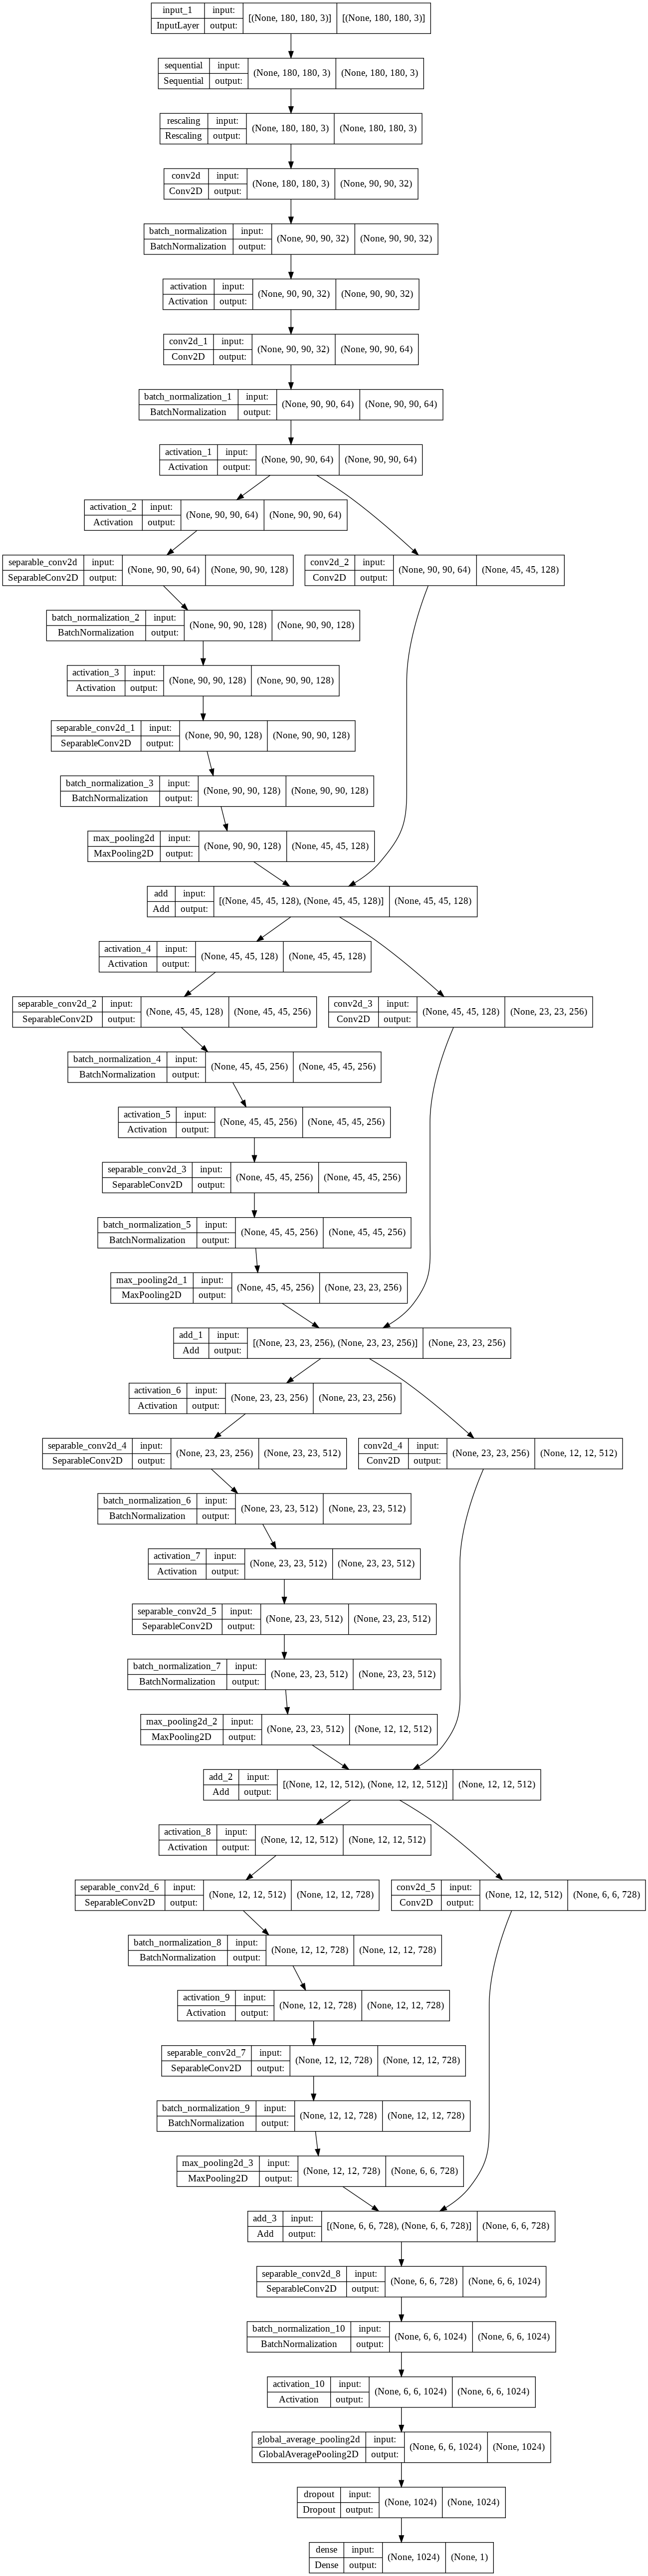

In [17]:
keras.utils.plot_model(model_relu, show_shapes=True)

In [18]:
model_relu.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 180, 180, 3)  0           ['input_1[0][0]']                
                                                                                                  
 rescaling (Rescaling)          (None, 180, 180, 3)  0           ['sequential[0][0]']             
                                                                                                  
 conv2d (Conv2D)                (None, 90, 90, 32)   896         ['rescaling[0][0]']          

**Train model**

Setting up hyperparameters for both models. 

> `epochs:` this is a variable that signifies how many times each sample in the training data has had the opportunity to work through the entire network for training. 

> `loss:` the loss function quantifies the deviation of the prediction output by the neural network to the expected output.

> `optimizer:` ties together the loss function and model parameters by updating the network based on the output of the loss function.


In [22]:
epochs = 5

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]

model_relu.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

model_leakyrelu.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

history_relu = model_relu.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

history_leaky_relu = model_leakyrelu.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/5
586/586 [==============================] - 156s 261ms/step - loss: 0.3778 - accuracy: 0.8346 - val_loss: 0.4368 - val_accuracy: 0.7898
Epoch 2/5
586/586 [==============================] - 157s 267ms/step - loss: 0.3572 - accuracy: 0.8438 - val_loss: 2.4061 - val_accuracy: 0.5329
Epoch 3/5
586/586 [==============================] - 158s 269ms/step - loss: 0.3286 - accuracy: 0.8597 - val_loss: 0.8419 - val_accuracy: 0.6670
Epoch 4/5
586/586 [==============================] - 156s 266ms/step - loss: 0.3091 - accuracy: 0.8720 - val_loss: 2.0411 - val_accuracy: 0.5393
Epoch 5/5
586/586 [==============================] - 159s 272ms/step - loss: 0.2948 - accuracy: 0.8741 - val_loss: 1.0755 - val_accuracy: 0.6422
Epoch 1/5
586/586 [==============================] - 160s 268ms/step - loss: 0.4073 - accuracy: 0.8164 - val_loss: 1.7888 - val_accuracy: 0.5387
Epoch 2/5
586/586 [==============================] - 157s 267ms/step - loss: 0.3733 - accuracy: 0.8347 - val_loss: 0.9705 - val_ac

**Run inference on new data**

[[0.9540029]]
[[0.7874325]]
Model 1 (ReLu): This image is 4.60 percent cat and 95.40 percent dog.
---
Model 2 (Leaky ReLu): This image is 21.26 percent cat and 78.74 percent dog.


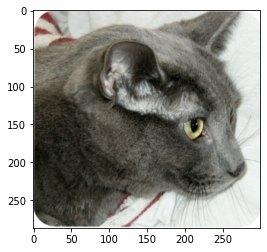

In [24]:
img = keras.preprocessing.image.load_img(
    "PetImages/Cat/6779.jpg", target_size=image_size
)

img_test = plt.imread("/content/PetImages/Cat/6779.jpg")

plt.imshow(img_test)

img_flatten = keras.preprocessing.image.img_to_array(img)
img_flatten = tf.expand_dims(img_flatten, 0) 

predictions_relu = model_relu.predict(img_flatten)
predictions_leakyrelu = model_leakyrelu.predict(img_flatten)

print(predictions_relu)
print(predictions_leakyrelu)

score_relu = predictions_relu[0]
score_leakyrelu = predictions_leakyrelu[0]

print(
    "Model 1 (ReLu): This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score_relu), 100 * score_relu)
)
print("---")
print(
    "Model 2 (Leaky ReLu): This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score_leakyrelu), 100 * score_leakyrelu) 
)

**Accuracy Report** (epochs=5)

>**Model 1 (using ReLu):** 64.22% 

> **Model 2 (using Leaky ReLu):** 72.53%

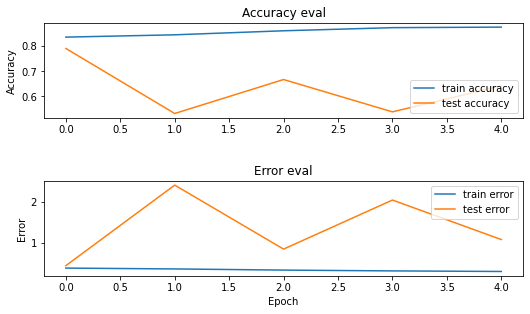

In [31]:
fig, axs = plt.subplots(2, figsize=(8,5))

# create accuracy sublpot
axs[0].plot(history_relu.history["accuracy"], label="train accuracy")
axs[0].plot(history_relu.history["val_accuracy"], label="test accuracy")
axs[0].set_ylabel("Accuracy")
axs[0].legend(loc="lower right")
axs[0].set_title("Accuracy eval")

# create error sublpot
axs[1].plot(history_relu.history["loss"], label="train error")
axs[1].plot(history_relu.history["val_loss"], label="test error")
axs[1].set_ylabel("Error")
axs[1].set_xlabel("Epoch")
axs[1].legend(loc="upper right")
axs[1].set_title("Error eval")

fig.tight_layout(pad=3.0)

plt.show()

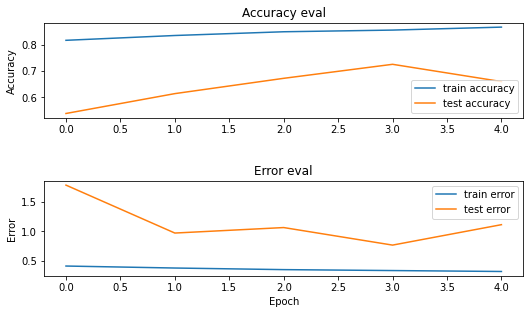

In [32]:
fig, axs = plt.subplots(2, figsize=(8,5))

# create accuracy sublpot
axs[0].plot(history_leaky_relu.history["accuracy"], label="train accuracy")
axs[0].plot(history_leaky_relu.history["val_accuracy"], label="test accuracy")
axs[0].set_ylabel("Accuracy")
axs[0].legend(loc="lower right")
axs[0].set_title("Accuracy eval")

# create error sublpot
axs[1].plot(history_leaky_relu.history["loss"], label="train error")
axs[1].plot(history_leaky_relu.history["val_loss"], label="test error")
axs[1].set_ylabel("Error")
axs[1].set_xlabel("Epoch")
axs[1].legend(loc="upper right")
axs[1].set_title("Error eval")

fig.tight_layout(pad=3.0)

plt.show()